In [1]:
import cudf
from sklearn.preprocessing import LabelEncoder

data = cudf.read_csv('agaricus-lepiota.data')

dataset_pd = data.to_pandas()

# Apply LabelEncoder to each column
label_encoder = LabelEncoder()
for column in dataset_pd.columns:
    dataset_pd[column] = label_encoder.fit_transform(dataset_pd[column])

dataset_pd

,edibility,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8120,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8121,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8122,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
data_pca = pca.fit_transform(dataset_pd)
data_pca

array([[-0.25315455, -0.32893654,  1.39470288],
       [ 1.95188293,  4.74444545,  3.57581342],
       [ 1.67784445,  2.41048651,  3.9207918 ],
       ...,
       [ 1.88301333,  0.45884613, -1.1618577 ],
       [-7.30488724, -1.27548472,  1.23267193],
       [ 4.86576994, -3.57533738,  0.07470086]])

In [3]:
from cuml.cluster import KMeans
from cuml.metrics.cluster import silhouette_score as metric_score

clusters = range(2, 31)
seeds = range(1)
results = []

clusters_calulated = 0

for seed in seeds:
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster, random_state=seed).fit(data_pca)
        score = metric_score(data_pca, kmeans.labels_)
        results.append([cluster, seed, score])

        clusters_calulated += 1
        print("Clusters calculated", clusters_calulated, end="\r")
        
    print(end="\r")

cudf.DataFrame(results, columns=['Clusters', 'Seed', 'Silhouette Score'])
results

[[2, 0, 0.44703074998249426],
 [3, 0, 0.437379185441524],
 [4, 0, 0.45504427711638323],
 [5, 0, 0.41157563523332413],
 [6, 0, 0.397986385239511],
 [7, 0, 0.4368690647862105],
 [8, 0, 0.4253801844499652],
 [9, 0, 0.4179363094709885],
 [10, 0, 0.41963860503089395],
 [11, 0, 0.4106788495607922],
 [12, 0, 0.41051337643506636],
 [13, 0, 0.4209976803817285],
 [14, 0, 0.4142432445758368],
 [15, 0, 0.4175407018047323],
 [16, 0, 0.3875633231648878],
 [17, 0, 0.3967958608096502],
 [18, 0, 0.400671768731081],
 [19, 0, 0.409329687404772],
 [20, 0, 0.4328975239704044],
 [21, 0, 0.4089475235629094],
 [22, 0, 0.406929856339872],
 [23, 0, 0.41023940299743317],
 [24, 0, 0.39951207564874597],
 [25, 0, 0.3992586865570742],
 [26, 0, 0.41588188088038003],
 [27, 0, 0.41424867705891993],
 [28, 0, 0.41920325890978866],
 [29, 0, 0.41151172773344263],
 [30, 0, 0.40426162304083174]]

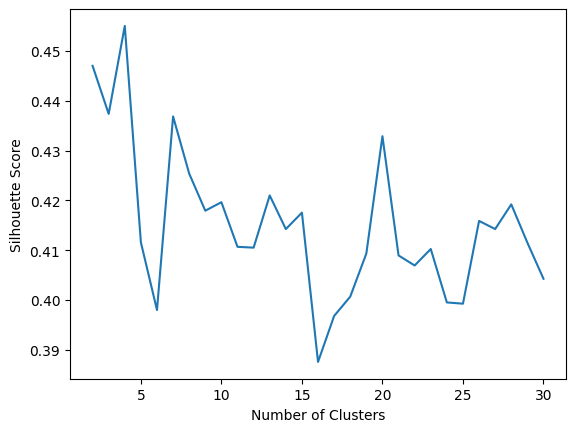

In [4]:
import matplotlib.pyplot as plt

# Extract column 2 from the results
scores = [result[2] for result in results]
clusters = [result[0] for result in results]

plt.plot(clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [5]:
%matplotlib notebook

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=11, random_state=0).fit(data_pca)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=kmeans.labels_, cmap='viridis', 
           marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


<IPython.core.display.Javascript object>